In [3]:
import pandas as pd
import numpy as np
from cataclop.ml.pipeline import factories

In [ ]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [885]:
d

In [13]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,17355.0,4.542380e+00,1.989305e+00,2.0,3.0,4.0,6.000,1.400000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,17355.0,1.251541e+01,3.037875e+00,4.0,10.0,13.0,15.000,2.000000e+01,int64
distance,17355.0,1.920982e+03,4.800349e+02,950.0,1600.0,2000.0,2200.000,3.200000e+03,int64
earnings,17355.0,6.586432e+06,2.246027e+07,0.0,515000.0,2123300.0,6220250.000,1.471275e+09,int64


In [14]:
import time

df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='inner')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(1000)

odds = pd.DataFrame(columns=['odds_{:d}'.format(i) for i in range(20)], index=df.index)

races = df.groupby('race_id')

start = time.time()

for (id, race) in races:
    odds_sorted = sorted(race['final_odds_ref'].values)
    odds.loc[race.index, ['odds_{:d}'.format(i) for i, v in enumerate(odds_sorted)]] = odds_sorted
    
end = time.time()
print(end - start)

df = pd.concat([df,odds], axis=1)

df[['odds_{:d}'.format(i) for i in range(20)]] = df[['odds_{:d}'.format(i) for i in range(20)]].fillna(1000.0)

df['speed'] = (df['distance'] / df['time']).fillna(1000)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(0.)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.sort_index()
df_orig = df.copy()

336.8711278438568


In [15]:
#df = df_orig[df_orig['category']=='ATTELE'].copy()

In [962]:
df_test = df_orig[(df_orig['start_at'] > '2017-11-01') & (df_orig['category']=='PLAT')].copy()
df = df_orig[(df_orig['start_at'] <= '2017-11-01') & (df_orig['category']=='PLAT')].copy()
#df_test = df_orig[(df_orig['start_at'] > '2017-11-01')].copy()
#df = df_orig[(df_orig['start_at'] <= '2017-11-01')].copy()

df_test = df_test.sort_index()
df = df.sort_index()

In [963]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import log_loss, mean_absolute_error
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df.index.droplevel(1).values

group_kfold = GroupKFold(n_splits=3)

features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(20)]

N_TARGETS = 6

df['pred_pos'] = N_TARGETS
for i in range(N_TARGETS):
    df['pred_{}'.format(i+1)] = 0.0

df['target'] = df['position'].copy()
df.loc[df['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df['target'].fillna(N_TARGETS, inplace=True)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'rf_10',
        'model': RandomForestClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_30',
        'model': RandomForestClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'ada_10',
        'model': AdaBoostClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'ada_30',
        'model': AdaBoostClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'ada_100',
        'model': AdaBoostClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'knn_10',
        'model': KNeighborsClassifier(n_neighbors=10),
        'scaler': False
    },
    {
        'name': 'knn_30',
        'model': KNeighborsClassifier(n_neighbors=30),
        'scaler': False
    },
    {
        'name': 'knn_100',
        'model': KNeighborsClassifier(n_neighbors=100),
        'scaler': False
    }
]

for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0

    df['pred_{}'.format(model['name'])] = 0.0

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
        
        X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
        y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        df.loc[idx, 'pred_{}'.format(model['name'])] = p[:, list(clf.classes_).index(1)]
    
        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

    
    
    
    

rf_10 5.950260864143573
rf_30 2.4379387880011887
rf_100 1.5160358952266275
ada_10 1.7431831696394233
ada_30 1.7721020414329245
ada_100 1.7800276756270756
knn_10 6.684706578755187
knn_30 1.8641681826759136
knn_100 1.486780034031899
rf_10 6.365348983657527
rf_30 2.1776385981140653
rf_100 1.5079000530157385
ada_10 1.741811766403068
ada_30 1.769988527144585
ada_100 1.7822125666408093
knn_10 6.546320158526158
knn_30 1.867629986969683
knn_100 1.4927683065474222
rf_10 6.475096514340669
rf_30 2.1094748860708044
rf_100 1.517613985696165
ada_10 1.7434162299705462
ada_30 1.77417909946381
ada_100 1.7852001124685883
knn_10 6.225450913179002
knn_30 1.9530196718986188
knn_100 1.4998608194419998


In [964]:
from gplearn.genetic import SymbolicTransformer

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']

N_GP_FEATURES = 10

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = 0.
    df_test['gp_feat_{}'.format(i+1)] = 0.
    
df_test['target'] = df_test['position'].copy()
df_test.loc[df_test['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df_test['target'].fillna(N_TARGETS, inplace=True)


X_train = df_test[features].copy()
y_train = df_test['target']

X_test = df[features].copy()
y_test = df['target']

X_train = X_train.values
X_test = X_test.values

gp = SymbolicTransformer(generations=10, population_size=2000,
                     hall_of_fame=100, n_components=N_GP_FEATURES,
                     function_set=function_set,
                     parsimony_coefficient=0.0005,
                     max_samples=0.9, verbose=1,
                     random_state=0, n_jobs=3)

gp.fit(X_train, y_train.values)

gp_features = gp.transform(X_test)

for i in range(N_GP_FEATURES):
    df['gp_feat_{}'.format(i+1)] = gp_features[:,i]


    

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.15 0.04150967078789689       12 0.20312161281594351 0.140199928906455     18.05s
   1     6.38 0.09968915062184357        5 0.21686046838397063 0.19825254742974507     22.29s
   2     7.23 0.13025920710052435        5 0.24581152313901466 0.22030686642618857     22.34s
   3     6.55 0.1427080471143653        7 0.25332901096412835 0.1550752489113706     19.92s
   4     7.16 0.15427103255286567       13 0.2564615654608883 0.12166521233221597     17.38s
   5     8.11 0.18358284597336658        9 0.2564818041632414 0.2048215208209793     14.06s
   6     6.93 0.19709534209276922        9 0.25965080952360925 0.18328172589043235     10.38s
   7     6.57 0.20119237602754383        9 0.2605683233227066 0.17829638128287956      6.78s
   8      6

In [965]:
df[['position'] + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]][0:10]

position  gp_feat_1  gp_feat_2  gp_feat_3  gp_feat_4  gp_feat_5  \
race_id id                                                                    
1       1        4.0   0.644611   0.643978   3.194383   0.636556   0.101015   
        2        1.0   0.558010   0.557200   2.608203   0.548660   0.082479   
        3        5.0   0.490966   0.489977   2.258770   0.480290   0.071429   
        4        3.0   0.790541   0.790107   4.517540   0.784008   0.142857   
        5        2.0   0.790541   0.790107   4.517540   0.784008   0.142857   
        6        6.0   0.790541   0.790107   4.517540   0.784008   0.142857   
        7        7.0   0.790541   0.790107   4.517540   0.784008   0.142857   
2       8        2.0   0.752046   0.751248   3.726780   0.742648   0.117851   
        9        3.0   0.922297   0.921750   5.270463   0.914676   0.166667   
        10       5.0   0.651012   0.649991   3.042903   0.640104   0.096225   

            gp_feat_6  gp_feat_7  gp_feat_8  gp_feat_9  gp_feat_10  
race_id id                                                          
1       1    0.643903   0.675530   0.644596   0.303459    0.652222  
        2    0.556503   0.610410   0.557983   0.282340    0.566800  
        3    0.488320   0.568051   0.490926   0.264836    0.500939  
        4    0.790337   0.803345   0.790534   0.336057    0.796719  
        5    0.790337   0.803345   0.790534   0.336057    0.796719  
        6    0.790337   0.803345   0.790534   0.336057    0.796719  
        7    0.790337   0.803345   0.790534   0.336057    0.796719  
2       8    0.751220   0.788118   0.752028   0.354035    0.760925  
        9    0.922059   0.937236   0.922290   0.392067    0.929506  
        10   0.649253   0.712145   0.650980   0.329396    0.661267

In [980]:

stacked_features = ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(3)]

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]
    
stacked_features = stacked_features# + ['gp_feat_{}'.format(i+1) for i in range(N_GP_FEATURES)]



In [981]:
from sklearn.linear_model import LogisticRegression
from gplearn.genetic import SymbolicRegressor

N_TARGETS_STACKED = 20

df['target_stacked'] = df['position'].copy()
df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED-1
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0


In [982]:

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], [])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target_stacked'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    
    #clf = MLPClassifier(hidden_layer_sizes=(60), alpha=0.01, activation='relu', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    '''
    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    p = clf.predict_proba(X_val)
    
    for i in range(N_TARGETS_STACKED):
        df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]
        
    '''
    
    from sklearn.ensemble import RandomForestRegressor
    
    #reg = MLPRegressor(batch_size=20)
    reg = RandomForestRegressor(n_estimators=200)
    reg.fit(X_train, y_train.values)
    
    p = reg.predict(X_test)
    df.loc[idx, 'pred_stacked'] = p
    
    print( mean_absolute_error(y_test.values, p) )



2.848938827260702
2.867570087907848
2.8565477169440867


In [969]:
#df[['position', 'final_odds_ref', 'pred_stacked'] + ['pred_stacked_{}'.format(i+1) for i in range(N_TARGETS_STACKED)]+['pred_{}_1'.format(m['name']) for m in models]][:10]
df[['position', 'category', 'final_odds_ref', 'pred_stacked']][:10]

position category  final_odds_ref  pred_stacked
race_id id                                                 
1       1        4.0     PLAT             2.5      3.177250
        2        1.0     PLAT            29.4      3.366667
        3        5.0     PLAT            27.9      2.903333
        4        3.0     PLAT            14.1      3.576667
        5        2.0     PLAT             2.2      3.676667
        6        6.0     PLAT             6.4      3.916667
        7        7.0     PLAT            21.4      3.526667
2       8        2.0     PLAT             4.2      3.355000
        9        3.0     PLAT             4.6      3.250000
        10       5.0     PLAT            15.7      3.005000

In [912]:
fi = pd.Series(clf.feature_importances_, index=stacked_features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False))

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [1039]:
#df_test['strat_1'] = df_test['pred_stacked_1']
#races = df_test.groupby('race_id')

#df['strat_1'] = df['pred_stacked_1']+df['pred_stacked_2']-df['pred_stacked_3']-df['pred_stacked_4']-df['pred_stacked_5']-df['pred_stacked_6']
df['strat_1'] = df['pred_stacked'] * (df['final_odds_ref'].fillna(1))
#df['strat_2'] = df['pred_stacked_2']
races = df.groupby('race_id')


bets = []

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(['strat_1'], 1):
    
        r = race.sort_values(by=target, ascending=False)

        #r = r[(r['final_odds_ref']<20.) & (r['final_odds_ref'] > 2)]
     
        N = 1
        for n in range(N):
            
            if len(r) <= N:
                continue

            player = r.iloc[n]

            if player['category'] != 'PLAT':
                continue

            if player['num'] in nums:
                continue

            odds = player['final_odds_ref']

            if np.isnan(odds) or odds > 20:
                continue

            '''

            if player['pred_1'] < 0.1:
                continue
            if player['pred_2'] < 0.075:
                continue
            if player['pred_3'] < 0.05:
                continue

            '''


            bet = 1#np.log(player['final_odds_ref'])#player['pred_1'] + player['pred_2']/2. + player['pred_3']/3.

            if odds < 3:
                bet = 1
            elif odds < 10:
                bet = 1
            else:
                bet = 1/odds

            bet = odds

            #bet = max(1., np.floor(1/odds*10))

            #bet = player['pred_stacked_1']*10

            profit = player['winner_dividend']/100.0 * bet - bet

            print(player['sub_category'], player['country'], player['declared_player_count'], player['final_odds_ref'], race['final_odds_ref'].describe())

            bets.append( (id, player['sub_category'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], player['pred_stacked_2'], player['pred_stacked_3'], player['num'], profit) )

            nums.append(player['num'])



bets = pd.DataFrame(bets, columns=['id', 'cat', 'date', 'bet', 'pos', 'odds', 'pred_1', 'pred_2', 'pred_3', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['bets'] = bets['bet'].cumsum()
bets['stash'] = bets['profit'].cumsum()


GROUPE_I FRA 6 15.7 count     6.000000
mean      7.750000
std       5.802327
min       2.500000
25%       4.300000
50%       4.750000
75%      12.175000
max      15.700000
Name: final_odds_ref, dtype: float64
COURSE_A_CONDITIONS FRA 10 15.4 count     9.000000
mean      9.211111
std       4.171164
min       4.600000
25%       4.900000
50%       8.600000
75%      12.300000
max      15.400000
Name: final_odds_ref, dtype: float64
COURSE_A_CONDITIONS CHL 12 17.9 count     8.000000
mean      8.750000
std       4.927764
min       2.800000
25%       5.325000
50%       7.850000
75%      10.775000
max      17.900000
Name: final_odds_ref, dtype: float64
COURSE_A_CONDITIONS FRA 9 16.3 count     8.000000
mean      9.800000
std       5.043808
min       2.300000
25%       6.200000
50%      10.150000
75%      13.625000
max      16.300000
Name: final_odds_ref, dtype: float64
A_RECLAMER FRA 8 17.5 count     7.000000
mean     10.142857
std       6.037344
min       1.700000
25%       7.150000
50%       8.

A_RECLAMER FRA 7 16.1 count     7.000000
mean      9.742857
std       5.937973
min       2.500000
25%       4.000000
50%      13.200000
75%      14.200000
max      16.100000
Name: final_odds_ref, dtype: float64
HANDICAP FRA 9 12.2 count     7.000000
mean      8.000000
std       3.590729
min       2.100000
25%       6.500000
50%       7.100000
75%      10.800000
max      12.200000
Name: final_odds_ref, dtype: float64
A_RECLAMER FRA 7 18.2 count     7.000000
mean      8.514286
std       5.620032
min       3.000000
25%       4.500000
50%       5.600000
75%      11.900000
max      18.200000
Name: final_odds_ref, dtype: float64
COURSE_A_CONDITIONS FRA 5 7.5 count    5.000000
mean     4.940000
std      1.971801
min      2.300000
25%      3.900000
50%      5.100000
75%      5.900000
max      7.500000
Name: final_odds_ref, dtype: float64
COURSE_A_CONDITIONS FRA 7 19.3 count     7.000000
mean      9.771429
std       5.752308
min       1.900000
25%       6.550000
50%       9.100000
75%      12.5

In [1013]:
np.isnan(np.nan)

True

In [1040]:
print('bets:', (bets['bet']>0).sum())
print('bets:', bets['bet'].sum(), '€')
print('profits:', bets['profit'].sum(), '€')
print('returns:', 100. * (bets['profit'].sum() / bets['bet'].sum()), '%')
print('win rate:', 100. * (bets['profit']>0).astype('float').mean(), '%')

bets: 75
bets: 1152.1000000000001 €
profits: 2600.13 €
returns: 225.68613835604546 %
win rate: 16.0 %


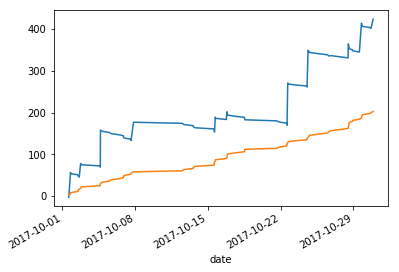

In [1036]:
import matplotlib
%matplotlib inline
bets['stash'].plot()
bets['bets'].plot()

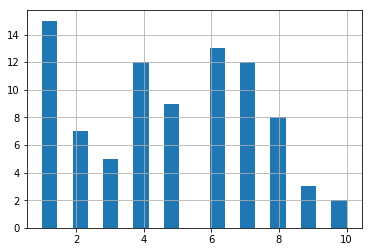

In [929]:
bets['pos'].hist(bins=20)

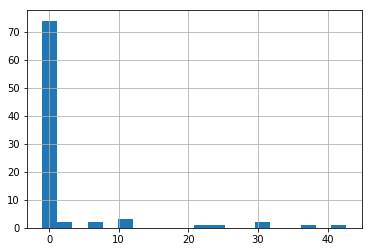

In [930]:
bets['profit'].hist(bins=20)

In [1038]:
bets[0:100]

,id,cat,date,bet,pos,odds,pred_1,pred_2,pred_3,num,profit,bets,stash
date,,,,,,,,,,,,,
2017-10-01 14:48:00,2,GROUPE_I,2017-10-01 14:48:00,2.753661,5.0,11.8,0.0,0.0,0.0,3,-2.753661,2.753661,-2.753661
2017-10-01 18:55:00,24,COURSE_A_CONDITIONS,2017-10-01 18:55:00,2.734368,1.0,19.0,0.0,0.0,0.0,9,59.335775,5.488028,56.582114
2017-10-01 19:35:00,26,COURSE_A_CONDITIONS,2017-10-01 19:35:00,2.884801,8.0,16.9,0.0,0.0,0.0,8,-2.884801,8.372829,53.697314
2017-10-02 11:55:00,44,COURSE_A_CONDITIONS,2017-10-02 11:55:00,2.791165,7.0,30.0,0.0,0.0,0.0,5,-2.791165,11.163994,50.906148
2017-10-02 12:55:00,46,A_RECLAMER,2017-10-02 12:55:00,2.862201,4.0,19.0,0.0,0.0,0.0,5,-2.862201,14.026195,48.043948
2017-10-02 15:08:00,50,HANDICAP_CATEGORIE_DIVISE,2017-10-02 15:08:00,2.587764,3.0,6.1,0.0,0.0,0.0,3,-2.587764,16.613959,45.456184
2017-10-02 18:13:00,56,INCONNU,2017-10-02 18:13:00,2.360854,1.0,14.8,0.0,0.0,0.0,3,32.579785,18.974813,78.035969
2017-10-02 19:13:00,58,HANDICAP_DIVISE,2017-10-02 19:13:00,2.990720,7.0,20.1,0.0,0.0,0.0,1,-2.990720,21.965533,75.045249
2017-10-04 15:06:00,128,GROUPE_III,2017-10-04 15:06:00,2.821379,3.0,23.9,0.0,0.0,0.0,6,-2.821379,24.786912,72.223870


cat     A_RECLAMER  COURSE_A_CONDITIONS  COURSE_A_CONDITION_QUALIF_HP  \
profit       -10.0            18.742857                         -10.0   
profit         7.0            35.000000                           1.0   

cat     GROUPE_I  GROUPE_II  GROUPE_III  HANDICAP  HANDICAP_CATEGORIE_DIVISE  \
profit     -10.0      -10.0       -10.0       4.4                      114.0   
profit       1.0        2.0         2.0      20.0                        5.0   

cat     HANDICAP_DE_CATEGORIE  HANDICAP_DIVISE  INCONNU  
profit                  -10.0            -10.0    -10.0  
profit                    1.0              3.0      2.0  


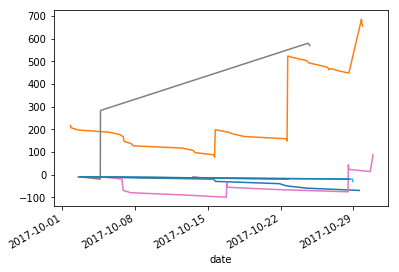

In [987]:
bets_cat = bets.groupby('cat')

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

for cat, b in bets_cat:
    b['profit'].cumsum().plot(label=cat)
